# 1 - Perkenalan

Name : Jason Rich Darmawan Onggo Putra

Batch : 016 RMT

Data set Overview : 

Objective :

# 2 - Import Libraries

In [23]:
# Data Loading
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np

# EDA
import matplotlib.pyplot as plt
import seaborn as sns

# 3 - Data Loading

- columns that are not good separator of the target: ['customerID']

In [2]:
# Load the data set
df = pd.read_csv("./WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Preview the data set
with pd.option_context("display.max.columns", None):
    display(df.head())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


> [Nominal data (from the Latin word “nomen” meaning “named” data), is data that names or labels variables without a numerical value. The simplest example would be “yes” or “no.” These are two categories, but there is no way to order them from highest to lowest or best to worst.](https://www.google.com/search?q=is+yes+and+no+ordinal&oq=is+yes+and+no+ordinal&aqs=edge..69i57j69i64.3078j0j1&sourceid=chrome&ie=UTF-8#:~:text=7%20Considerations%20for,com%20%E2%80%BA%20Blog)

- Some nominal columns have somewhat ordered category e.g column 'OnlineSecurity' have values 'Yes', 'No', 'No internet service'. However, the ordered category argument is weak, e.g when we ask Is 'No' better than 'No internet service'?. Therefore, we concludes it as nominal columns.

- nominal columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'PaymentMethod']
- numerical columns: ['tenure', 'MonthlyCharges', 'TotalCharges']
- ordinal columns: ['Contract']

- target is nominal: 'Churn'

TODO
- [ ] Change nominal columns dtypes to 'category' with unordered categories.
  - double check 'SeniorCitizen'.
- [ ] Change 'Contract' dtypes to 'category' with ordered categories.
- [ ] Change 'TotalCharges' dtypess to 'float64' (dedicated for numerical columns).
- [ ] Change 'Churn' dtypes to 'category' with ordered categories.

In [3]:
# Check dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
# TotalCharges have ' ' value.
# df['TotalCharges'].astype('float64')

In [4]:
# Define columns
# Philosophy: Do not change anything until Data Preprocessing to simulate the real world.
nom_cols = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
    'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'PaymentMethod'
]
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
ord_cols = ['Contract']
target = 'Churn'

cat_cols = np.concatenate([nom_cols, ord_cols], axis=0)

# 4 - Exploratory Data Analysis (EDA)

- 'Gender', 'Partner' ratio 1:1-ish
- 'SeniorCitizen' ratio 5:2 (No:Yes)

- 'PhoneService' ratio 0.7:6.3 (No:Yes)
  - 'MultipleLines' top is 'No'. The majority do not have multiple lines.

- 'InternetService' top is 'Fiber optic'.
  - 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies' top is 'No'.

- 'PaperlessBilling' ratio 3:4 (No:Yes)
- 'PaymentMethod' top is 'Electronic check'.
- 'Contract' top is 'Month-to-month'

In [5]:
# Central Tendency categorical columns
df[cat_cols].astype('category').describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,Contract
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,2,4,3
top,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,Electronic check,Month-to-month
freq,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,4171,2365,3875


- 'gender' is not a good separator of the target.
- 'SeniorCitizen': **senior citizen** is more likely to churn.
- 'Partner': customer with **no partner** is more likely to churn.
- 'Dependents': customer with **dependents** is more likely to churn.

- 'PhoneService', 'MultipleLines': is not a good separator of the target.

- 'InternetService': customer with **fiber optic** is more likely to churn.
  - 'OnlineSecurity': customer with **no online security** is more likely to churn.
  - 'OnlineBackup': customer with **no online backup** is more likely to churn.
  - 'DeviceProtection': customer with **no device protection** is morel likely to churn.
  - 'TechSupport': customer with **no tech support** is more likely to churn.

- Only 'StreamingTV' and 'StreamingMovies' (internet-related services that are offered to customer) that makes customer more likely to churn if they have internet service. It does make sense too. Why would a customer pay extra for TV and/or Movies that can be watched online nowadays.

  - 'StreamingTV': customer with **no internet service** is less likely to churn.
  - 'StreamingMovies': customer with **no internet service** is less likely to churn.

- 'PaperlessBilling': customer with **paperless billing** is more likely to churn.
- 'PaymentMethod': customer paying with **electronic check** is more likely to churn.
- 'Contract': customer **paying monthly** is more likely to churn.

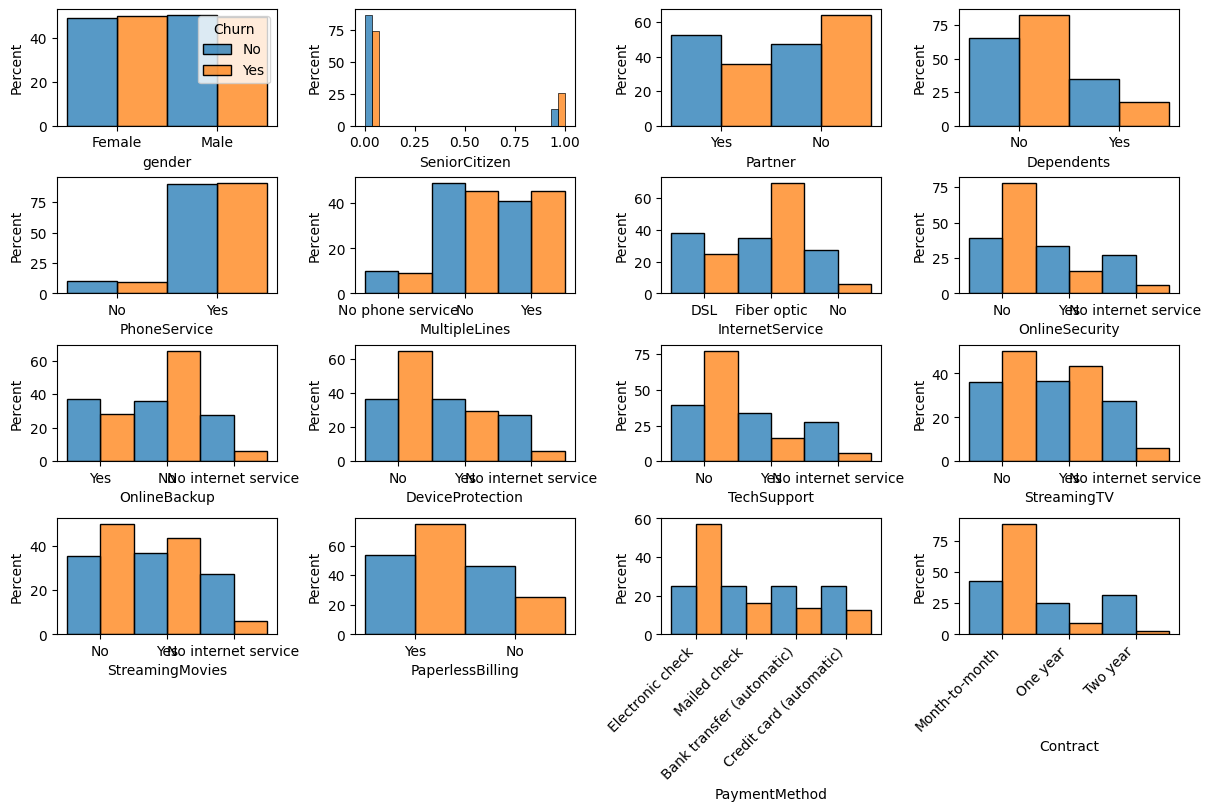

In [112]:
# reference: https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib
def isolate():
    fig, axes = plt.subplots(4,4, figsize=(12,8), layout='constrained')

    for column, ax in zip(cat_cols, axes.ravel()):
        sns.histplot(data=df, x=column, hue=target, multiple='dodge', 
            stat='percent', common_norm=False, 
        ax=ax)
        if column != 'gender':
            ax.get_legend().set_visible(False)
        if column in ['PaymentMethod', 'Contract']:
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

isolate()

- 'TotalCharges' is moderately skewed to the right.

In [21]:
# Central Tendency numerical columns
def isolate():
    df_c = df.copy()
    df_c['TotalCharges'] = pd.to_numeric(df_c['TotalCharges'], errors='coerce')
    with pd.option_context("float_format", "{:,.2f}".format):
        display(df_c[num_cols].describe())
        display(df_c[num_cols].skew())

isolate()

,tenure,MonthlyCharges,TotalCharges
count,"7,043.00","7,043.00","7,032.00"
mean,32.37,64.76,"2,283.30"
std,24.56,30.09,"2,266.77"
min,0.00,18.25,18.80
25%,9.00,35.50,401.45
50%,29.00,70.35,"1,397.47"
75%,55.00,89.85,"3,794.74"
max,72.00,118.75,"8,684.80"


tenure            0.24
MonthlyCharges   -0.22
TotalCharges      0.96
dtype: float64

# 5 - Data Preprocessing

In [ ]:
# Change nominal features dtypes to 'object'.
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')

In [ ]:
# Change ordinal features dtypes to 'category'
Contract_cat = CategoricalDtype(categories=['Month-to-month', 'One year', 'Two year'])
df['Contract'] = df['Contract'].astype(Contract_cat)

In [ ]:
# Change numerical features dtypes to number
# errors='coerce' invalid parsing will be set as NaN.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [ ]:
# Check missing values
df.isnull().sum()

# 6 - Model Definition

# 7 - Model Training

# 8 - Model Evaluation

# 9 - Model Saving

# 10 - Model Inference

# 11 - Pengambilan Keputusan